# Exploring SHAP feature attributions in image classification

This notebook explores how to interpret predictions of an image classification neural network using [SHAP](https://arxiv.org/abs/1705.07874).

The goals of the experiments are to:

1. Explore how SHAP explain the predictions. This experiment uses a (fairly) accurate network to understand how SHAP attributes the predictions.
1. Explore how SHAP behaves with innacurate predictions. This experiment uses a network with lower accuracy and prediction probabilities that are less robust (more spread among the classes) to understand how SHAP behaves when the predicitons are not reliable (a hat tip to [Dr. Rudin's work](https://arxiv.org/abs/1811.10154)).


SHAP has multiple explainers. The code uses the DeepExplainer explainer because it is the one used in the [image classification SHAP sample code](https://shap.readthedocs.io/en/latest/image_examples.html).

The code is based on the [SHAP MNIST example](https://shap.readthedocs.io/en/stable/example_notebooks/image_examples/image_classification/PyTorch%20Deep%20Explainer%20MNIST%20example.html), available as notebook [on GitHub](https://github.com/slundberg/shap/blob/master/notebooks/image_examples/image_classification/PyTorch%20Deep%20Explainer%20MNIST%20example.ipynb). This notebook uses the PyTorch sample code because at this time (April 2021), SHAP does not support TensorFlow 2.0. [This GitHub issue](https://github.com/slundberg/shap/issues/850) tracks the work to support TensorFlow 2.0 in SHAP.

In [1]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import models as m

## Experiment 1 - accurate network

In this experiment we train a network to a (fairly) accurate level, then use SHAP to explain the feature attributions for the network predictions.

The goal of this section is to explore how SHAP feature attribution works. In other words, to explore if we can understand how the network is making the predictions.

### Train the network

In [2]:
model_accurate = m.Net().to(m.DEVICE)
m.train_model(model_accurate, 8)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306635
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.297032
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.802942

Test set: Average loss: 0.0046, Accuracy: 8899/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.739931
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.413033
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.475584

Test set: Average loss: 0.0024, Accuracy: 9376/10000 (94%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.447328
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.424036
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.361521

Test set: Average loss: 0.0018, Accuracy: 9528/10000 (95%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.279950
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.299818
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.425154

Test set: Average loss: 0.0014, Accuracy: 9624/10000 (96%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.269576
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.407938
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.191578

Test set: Average loss: 0.0012

### Prepare a batch of images for feature attribution

Extract a batch of images and their labels from the test set.

In [3]:
images, targets = next(iter(m.test_loader))

"Select a set of background examples to take an expectation over" (from the [SHAP README](https://github.com/slundberg/shap#deep-learning-example-with-deepexplainer-tensorflowkeras-models))

In [4]:
BACKGROUND_SIZE = 100
background_images = images[:BACKGROUND_SIZE]
background_targets = targets[:BACKGROUND_SIZE].numpy()

What is left from the test batch will be used to show feature attribution.

In [5]:
test_images = images[BACKGROUND_SIZE:]
test_targets = targets[BACKGROUND_SIZE:].numpy()

**TO INVESTIGATE**: the way I understand how SHAP works, it would be more precise in the attributions if the backgound images had equal number of samples for each class (digit). However, because we are using the test set loader, we get a random sampe of the images. To try later: modify the code to load an equal number of images for each class.

For now we will just check the distribution of the images and eyeball if we are getting a similar percentage of digits in the background image list.

In [6]:
print('Digits:     ', end='')
[print('{:6}'.format(x), end='') for x in range(0, 10)];
print('\nBackground: ', end='')
[print('{:6.1%}'.format(x), end='') 
    for x in np.bincount(background_targets)/background_targets.shape[0]];
print('\nTest:       ', end='')
[print('{:6.1%}'.format(x), end='')
     for x in np.bincount(test_targets)/test_targets.shape[0]];

Digits:          0     1     2     3     4     5     6     7     8     9
Background:  13.0% 16.0%  7.0%  7.0% 10.0%  7.0% 11.0% 10.0%  9.0% 10.0%
Test:         3.6% 14.3%  7.1% 14.3% 10.7% 10.7%  3.6%  7.1% 14.3% 14.3%

Get their predicted probabilities and predicted label (with argmax).

In [7]:
output = model_accurate(images.to(m.DEVICE))
# get the index of the max log-probability
pred = output.max(1, keepdim=True)[1] 
# convert to numpy only once to save time
pred_np = pred.numpy() 

### Show SHAP feature attributions

Show the SHAP feature atribution for each image. We could have passed the entire array of images to `image_plot`, but we would lose resolution with that (see the test code). Processing each image separately results in a larger graph, making the attributions easier to see.

How to read the attributions:

- Red pixels increases the probability of a class being predicted
- Blue pixels decrease the probability of a class being predicted

See an explanation of "red vs. blue" [on this page of the SHAP documentation](https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Image%20Multi%20Class.html#Visualizing-SHAP-values-output).

**NOTE** that a disadvantage of ploting each image separately is that the SHAP value scale changes from one image to the next. We cannot compare the colors from one image to others in this format. To compare colors acorss images we need to plot all of them with one call to `image_plot`, as it's done in the original sample code. See the test code after this section if you want to see all images in one plot.

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


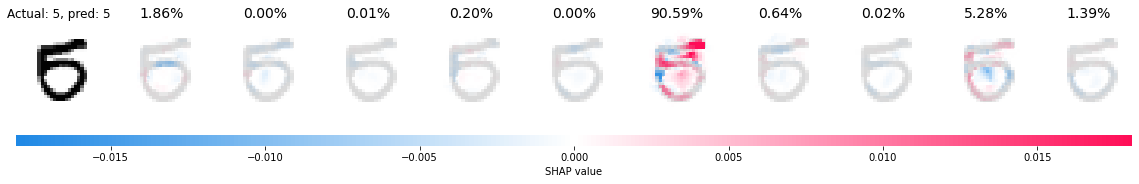

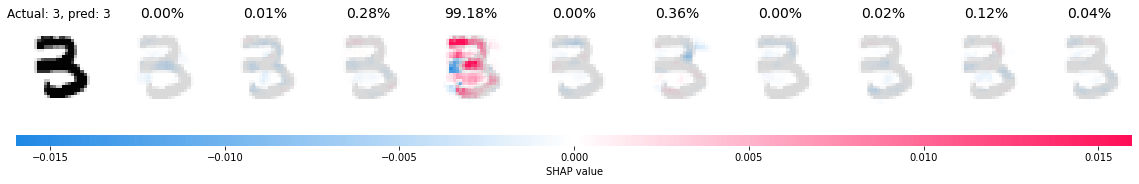

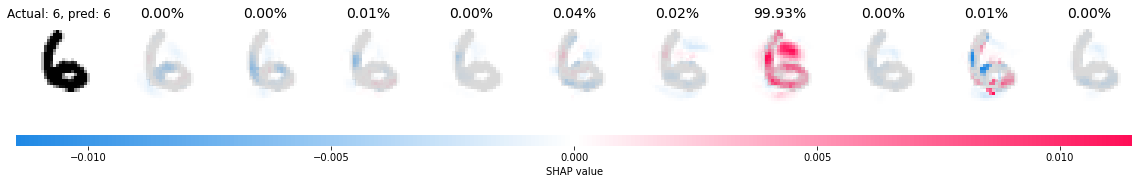

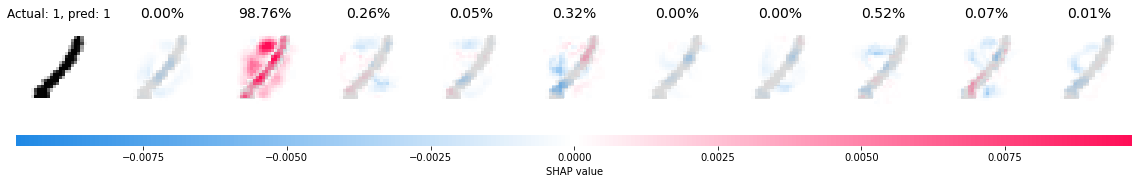

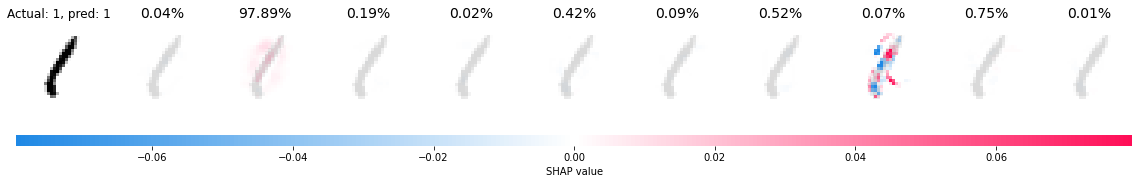

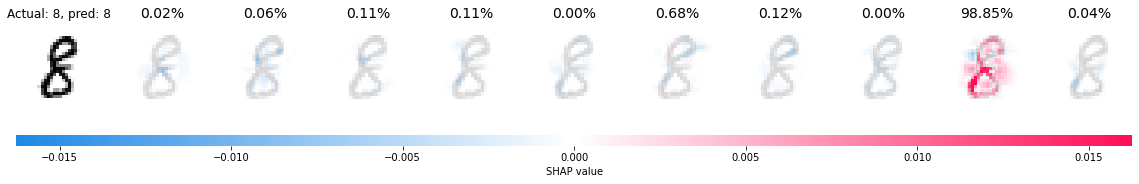

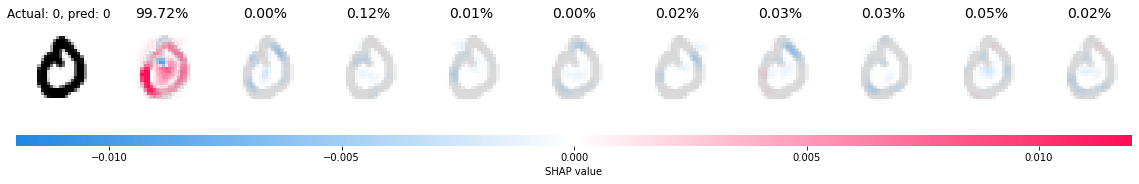

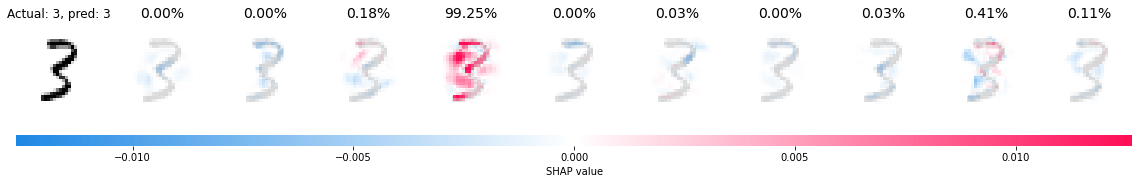

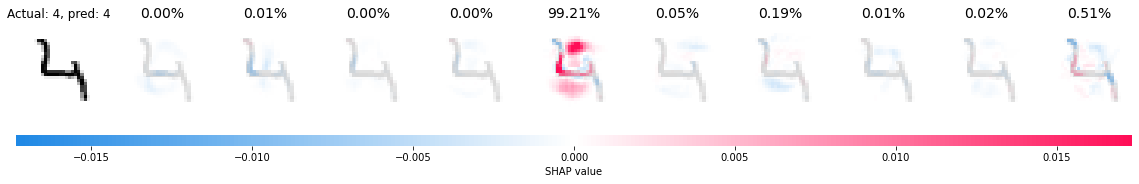

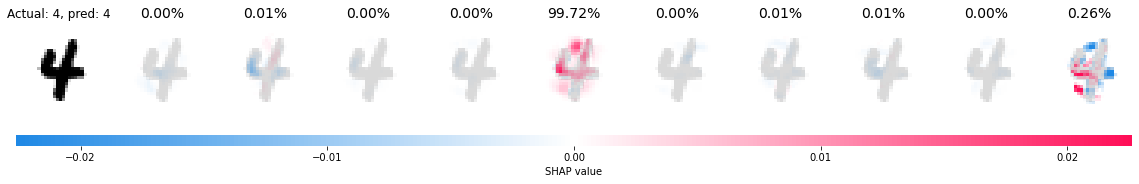

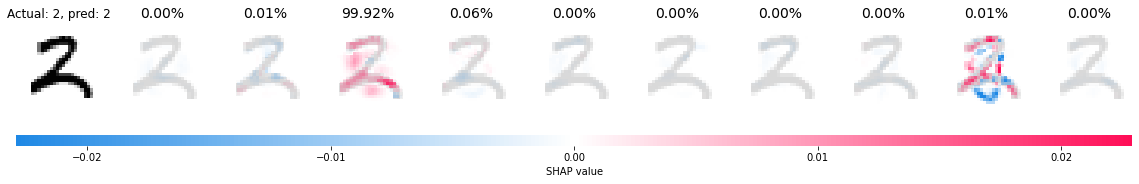

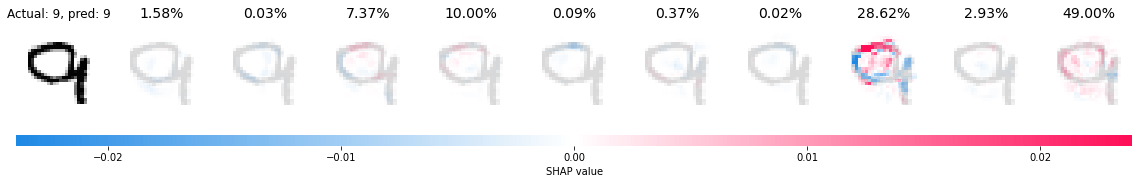

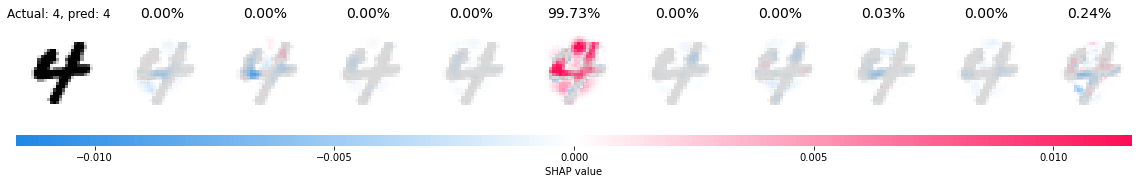

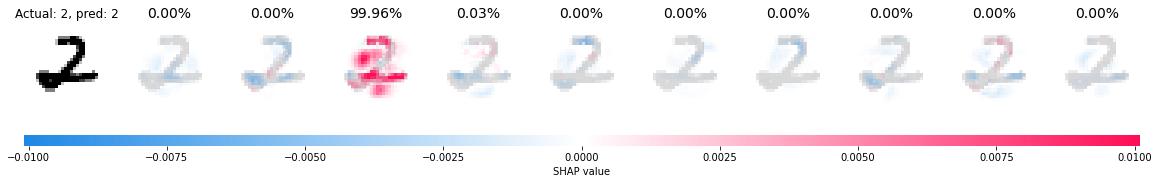

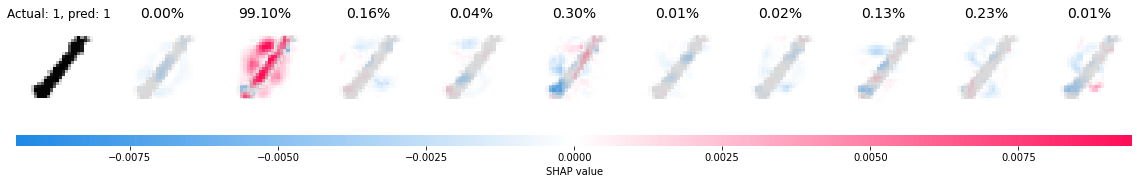

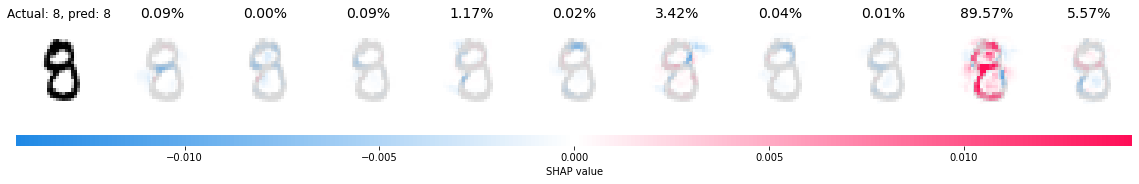

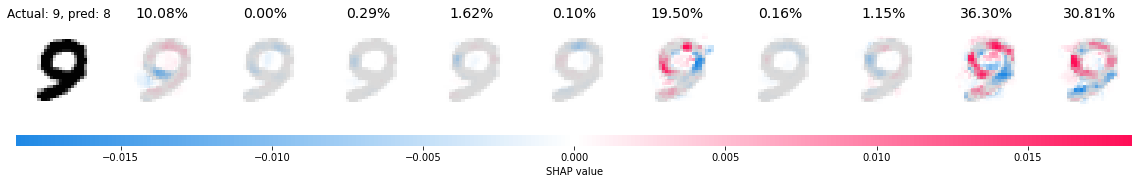

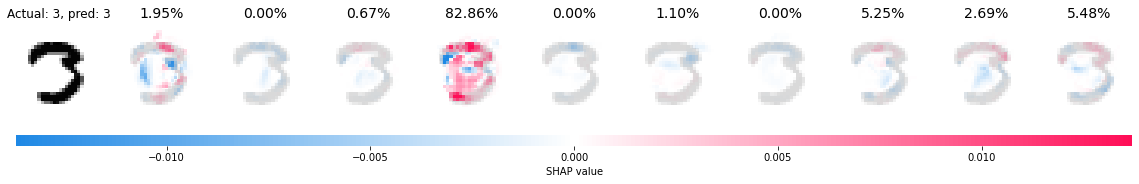

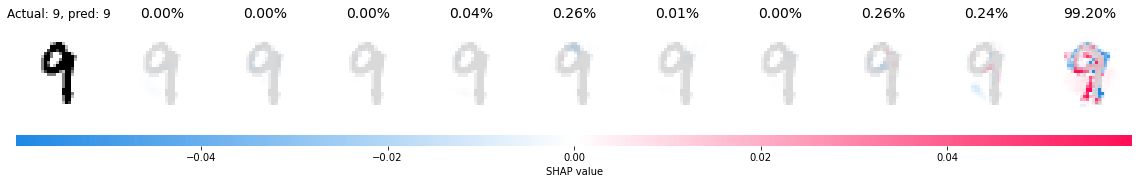

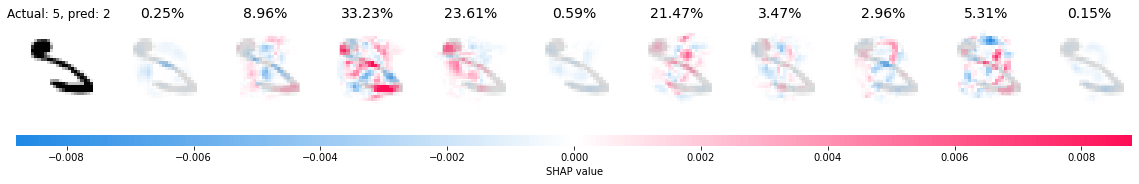

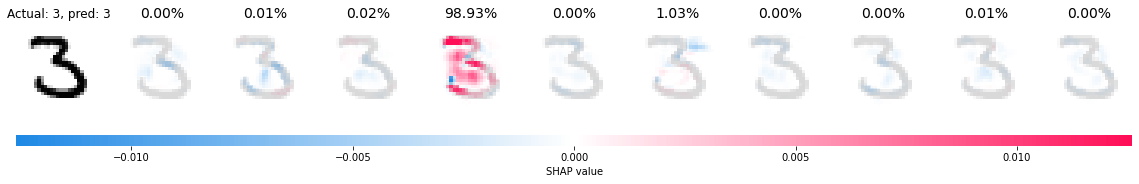

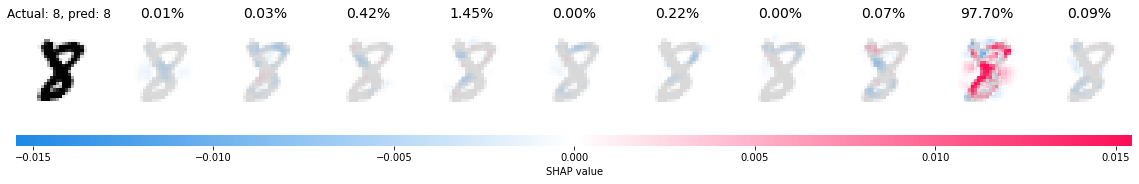

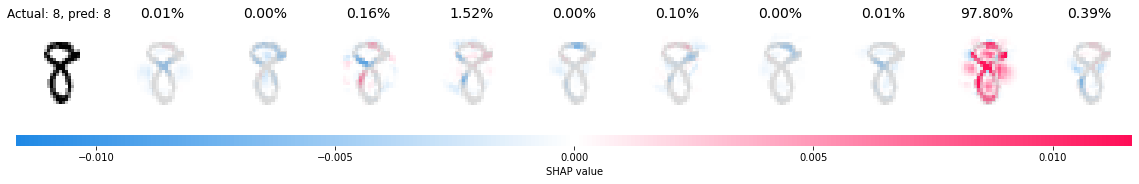

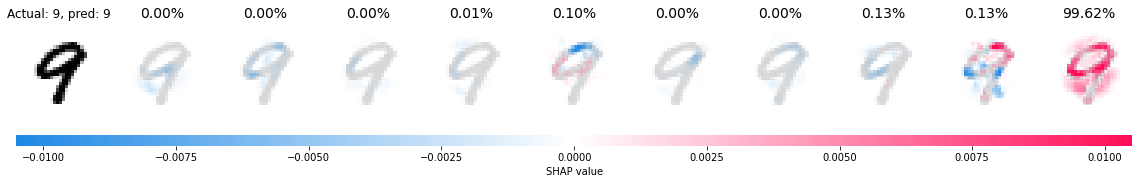

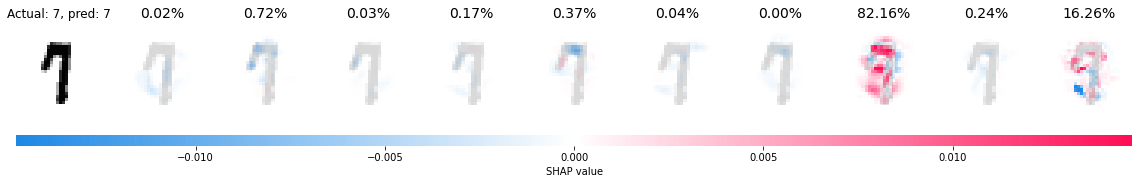

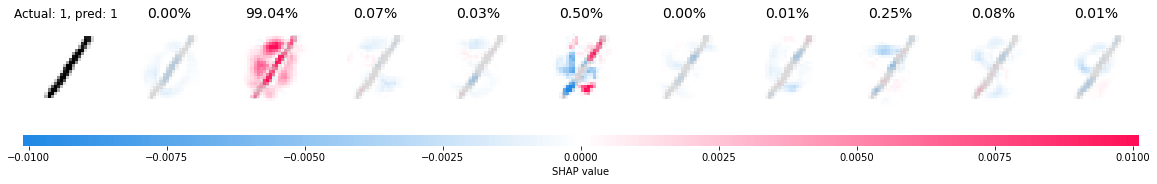

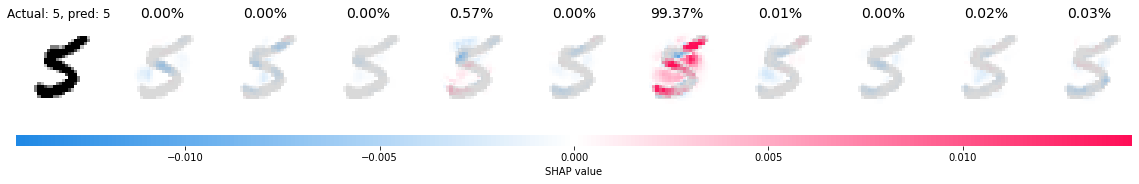

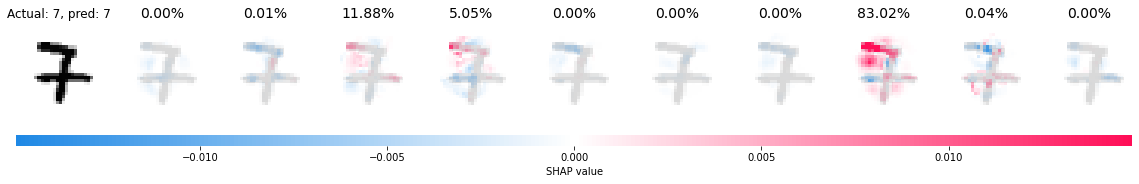

In [8]:
def show_attributions(model):
    # predict the probabilities of the digits using the test images
    output = model(images.to(m.DEVICE))
    # get the index of the max log-probability
    pred = output.max(1, keepdim=True)[1] 
    # convert to numpy only once to save time
    pred_np = pred.numpy() 

    expl = shap.DeepExplainer(model, background_images)

    for i in range(0, len(test_images)):
        ti = test_images[[i]]
        sv = expl.shap_values(ti)
        sn = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in sv]
        tn = np.swapaxes(np.swapaxes(ti.numpy(), 1, -1), 1, 2)

        # Prepare the attribution plot, but do not draw it yet
        # We will add more info to the plots later in the code
        shap.image_plot(sn, -tn, show=False)

        # Prepare to augment the plot
        fig = plt.gcf()
        allaxes = fig.get_axes()

        # Show the actual/predicted class
        allaxes[0].set_title('Actual: {}, pred: {}'.format(
            test_targets[i], pred_np[BACKGROUND_SIZE+i][0]))

        # Show the probability of each class
        # There are 11 axes for each picture: 1 for the digit + 10 for each SHAP
        # There is a last axis for the scale - we don't want to apply a label for that one
        prob = output[BACKGROUND_SIZE+i].detach().numpy()
        for x in range(1, len(allaxes)-1):
            allaxes[x].set_title('{:.2%}'.format(prob[x-1]), fontsize=14)
        plt.show()
        
show_attributions(model_accurate)

## Experiment 2 - inaccurate network

In this experiment we train a network only one epoch, resulting in an inaccurate network. Then use SHAP to explain the feature attributions for the network predictions again, as we did in the previous section.

The goal of this section is to understand how SHAP behaves when the predicitons are not reliable (a hat tip to [Dr. Rudin's work](https://arxiv.org/abs/1811.10154)).

### Train the network

In [9]:
model_inaccurate = m.Net().to(m.DEVICE)
m.train_model(model_inaccurate, 1)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.297604
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.246107
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.754595

Test set: Average loss: 0.0048, Accuracy: 8890/10000 (89%)



### Show SHAP feature attributions

Note that we reuse the same batch of images from the previous section. Holding the images constant allows us to compare the behavior of SHAP when only the model changes.

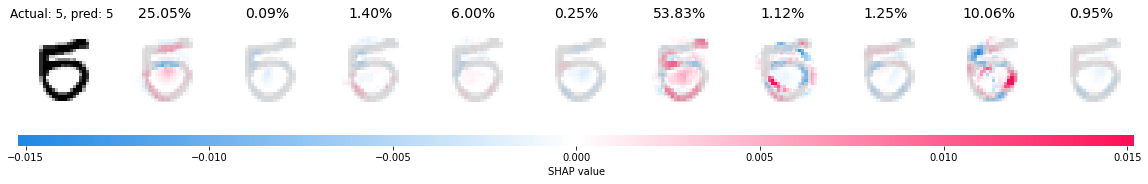

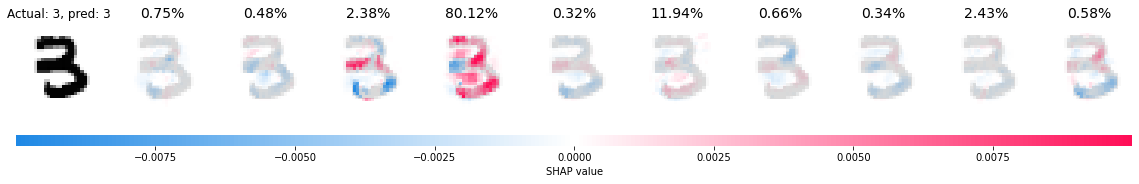

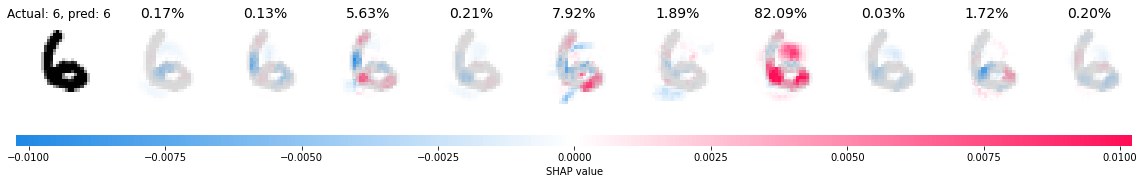

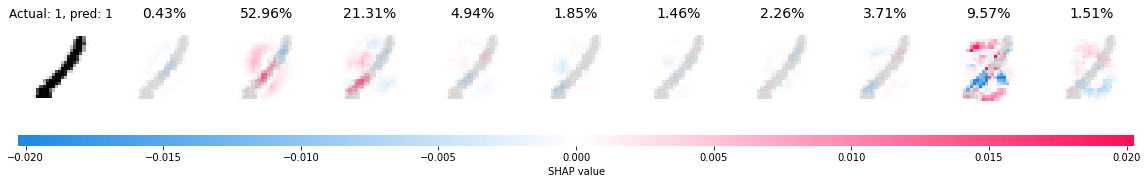

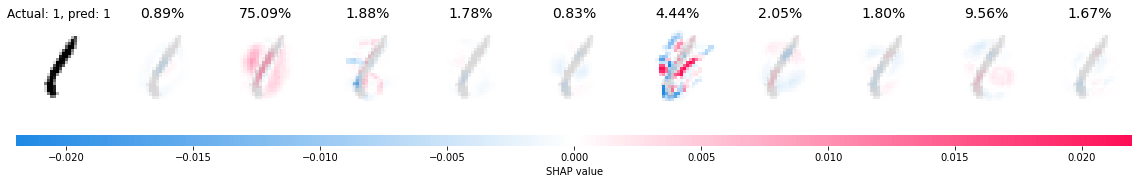

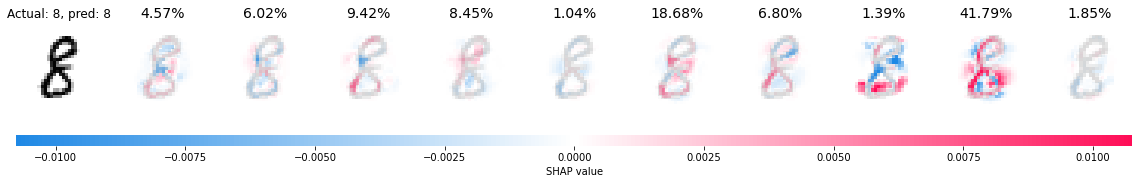

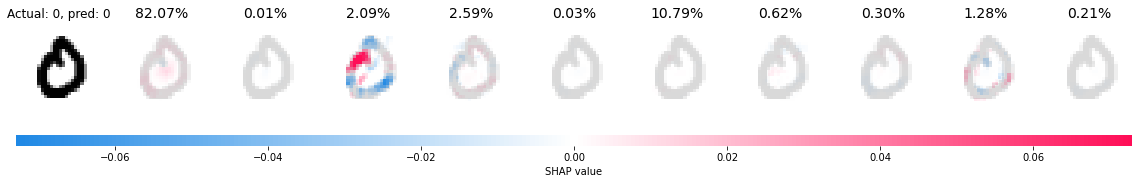

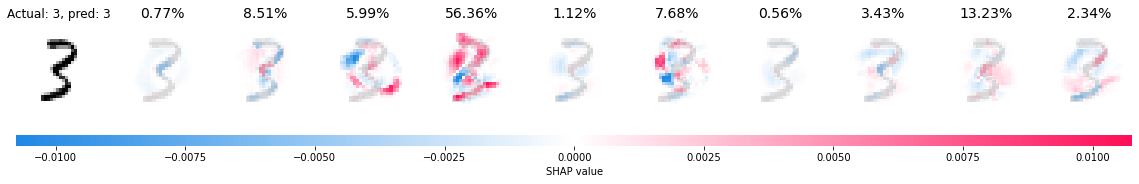

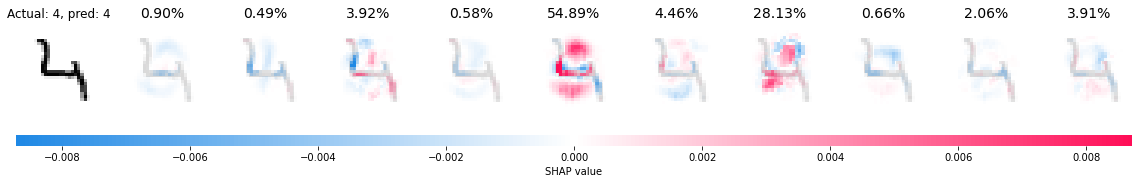

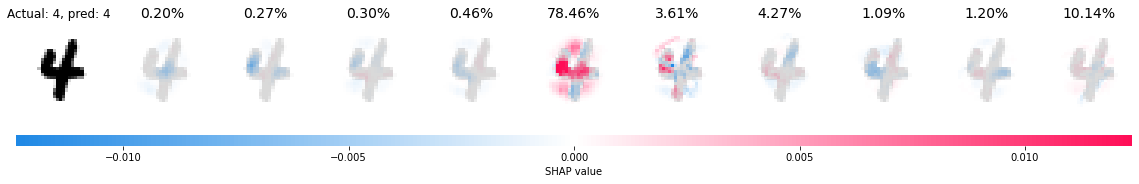

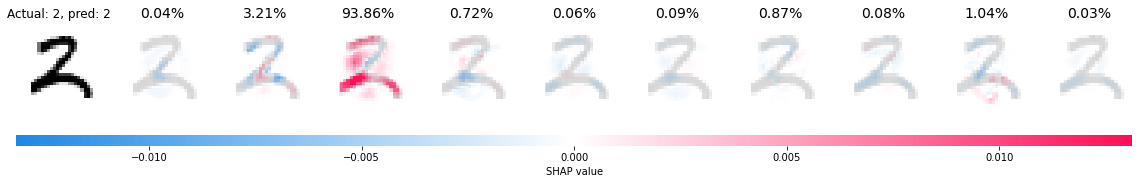

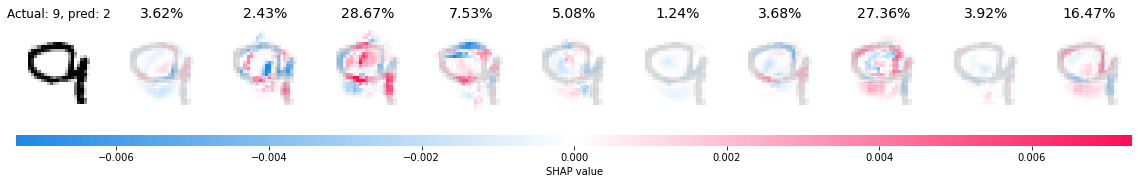

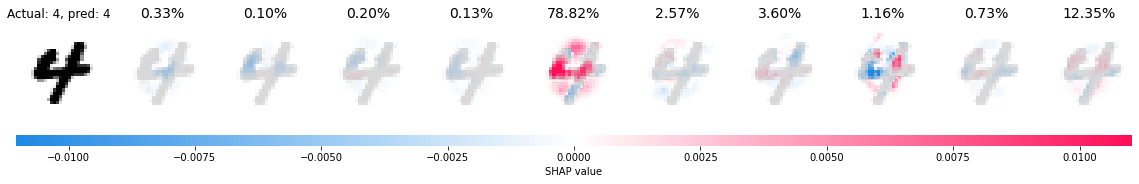

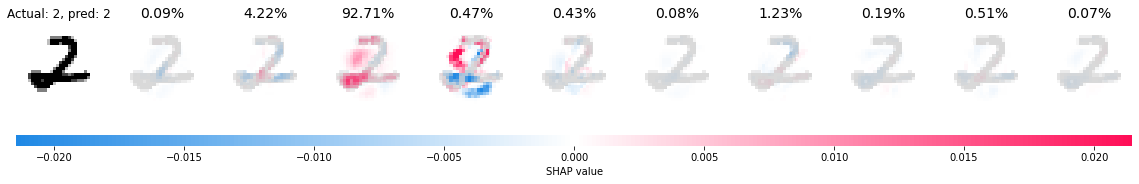

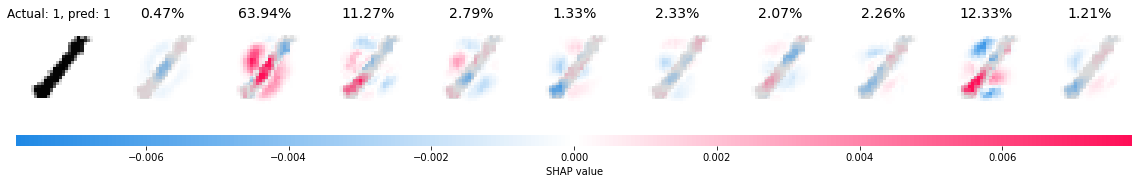

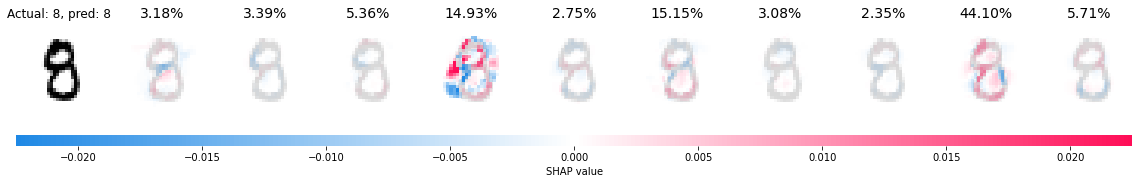

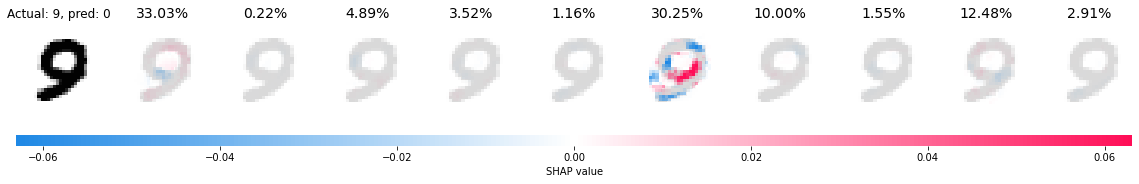

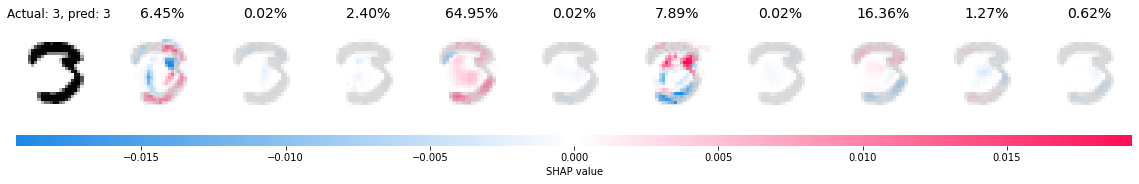

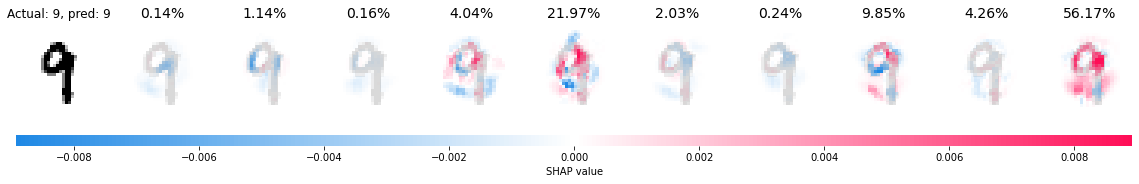

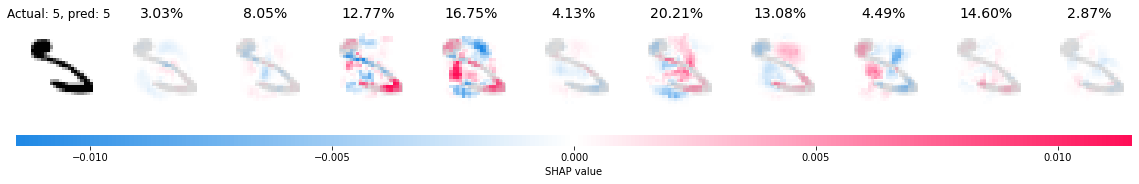

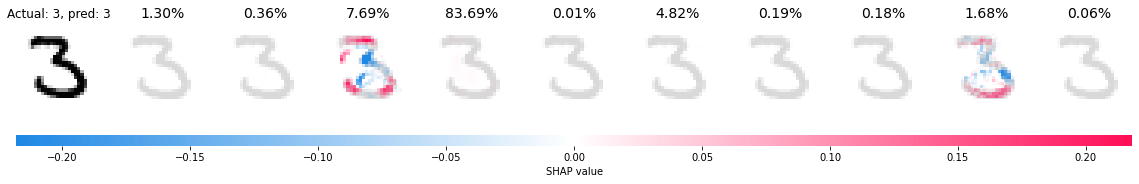

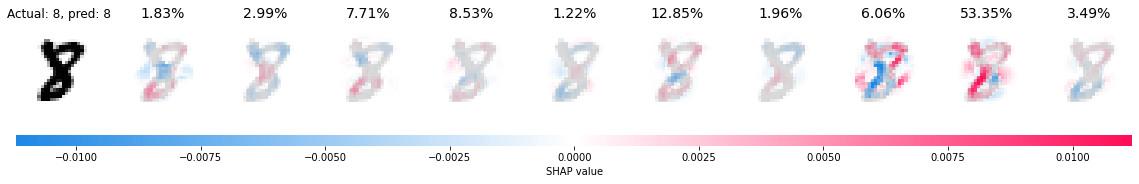

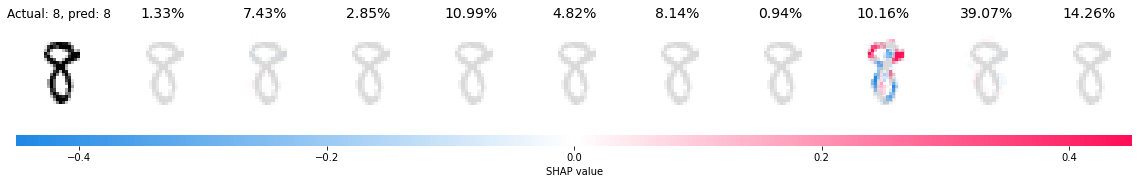

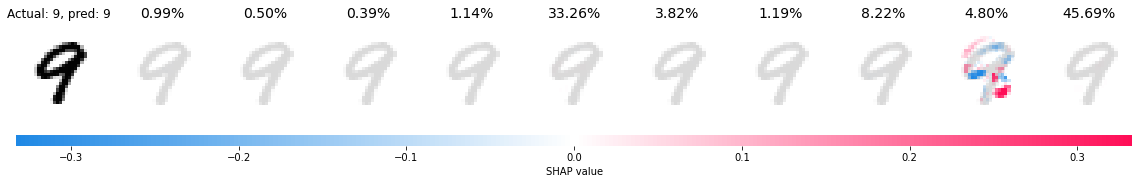

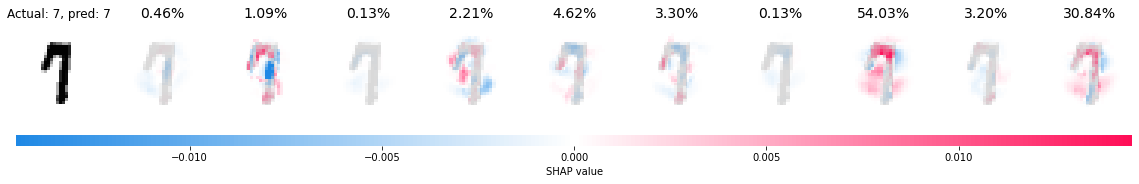

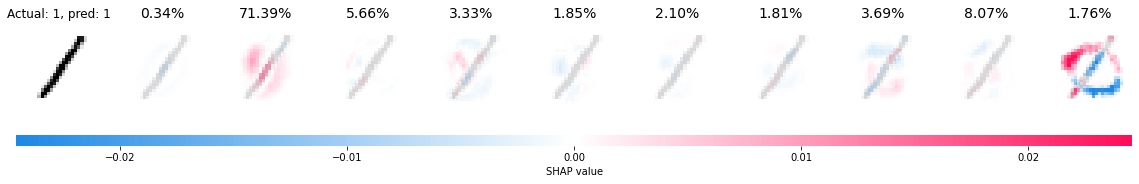

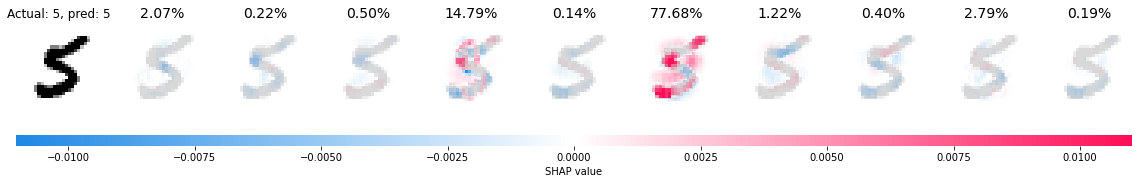

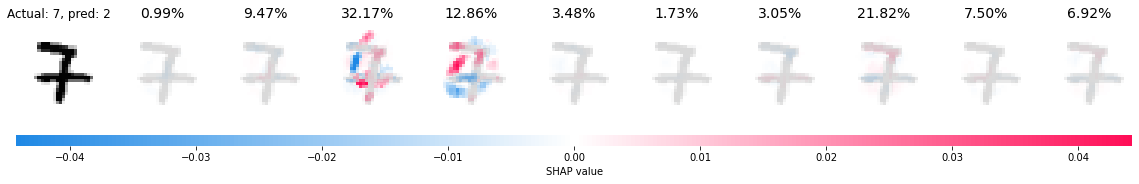

In [10]:
show_attributions(model_inaccurate)

------

# Test code

This section has the original code from the [SHAP MNIST example](https://shap.readthedocs.io/en/stable/example_notebooks/image_examples/image_classification/PyTorch%20Deep%20Explainer%20MNIST%20example.html). Use this section to check that the code in the previous section is showing the correct SHAP images.

To make the code comparable, we reuse the same images loaded in the previous section, but we redo all calculations following the sample code, to ensure that we didn't introduce a bug in the previous section.

The sequence of digits in this section and their feature attributions must match the ones in the previous sections.

In [11]:
# Turn the test code on when needed to not pollute the notebook
TEST_CODE = True

# Model to test
modelTest = model_inaccurate

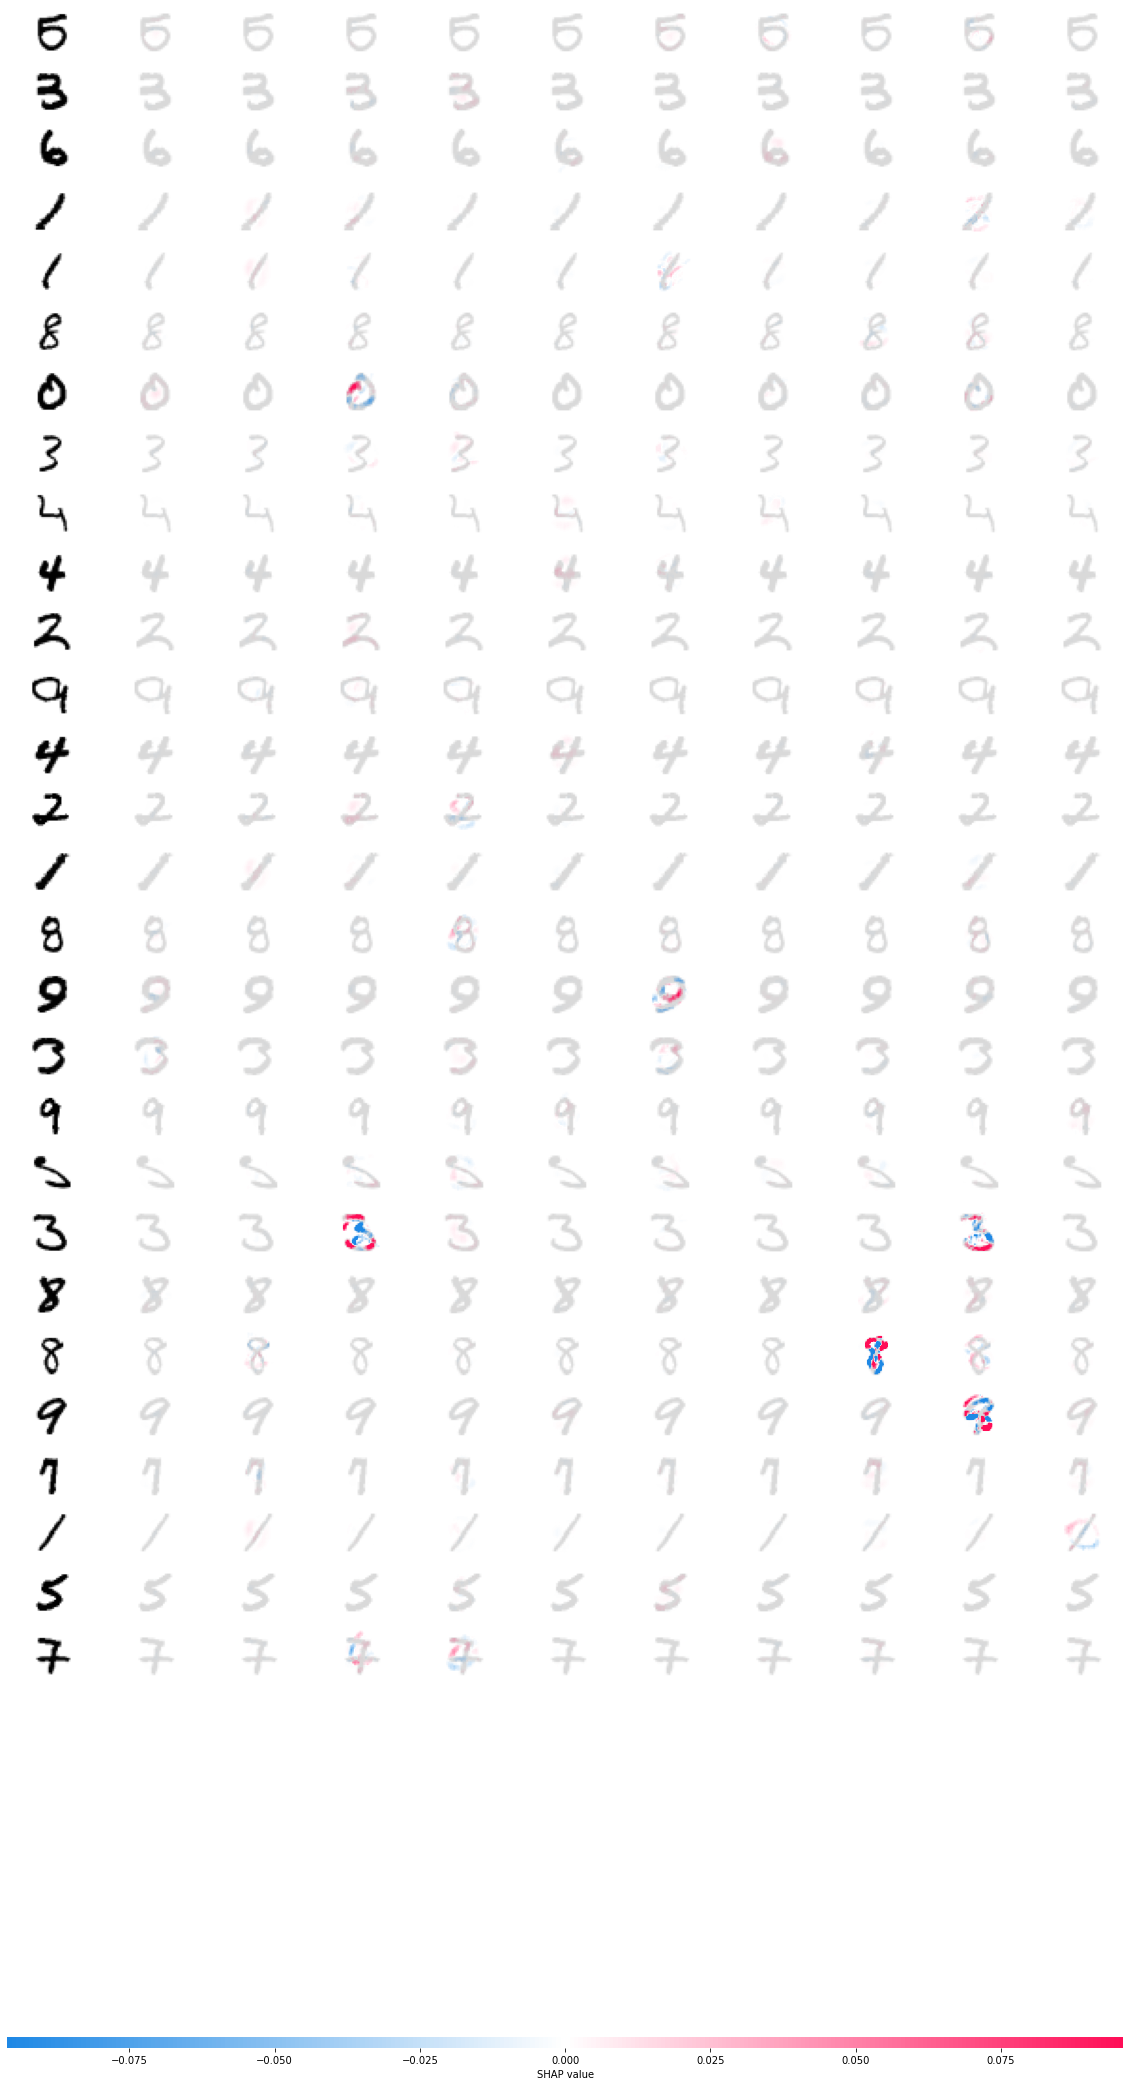

In [12]:
if TEST_CODE:
    e = shap.DeepExplainer(modelTest, background_images)
    shap_values = e.shap_values(test_images)
    
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)
    
    shap.image_plot(shap_numpy, -test_numpy)